In [ ]:
# all imports
import os
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm

In [3]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)
print("PIL version : ", PIL.__version__)

!python --version

torch version :  2.9.0+cpu
torchvision version :  0.24.0+cpu
torchinfo version :  1.8.0
numpy version :  2.3.4
matplotlib version :  3.10.7
PIL version :  12.0.0
Python 3.13.5


In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


In [5]:
data_dir = "D:\\WorldQuantUniversity\\Projects\\PlantDiseaseDetection\\data"

print("Data Directory:", data_dir)

Data Directory: D:\WorldQuantUniversity\Projects\PlantDiseaseDetection\data


In [6]:
classes = os.listdir(data_dir)

print(f"Number of classes: {len(classes)}")

for c in classes:
    print(c)


Number of classes: 23
Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___healthy
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Corn_(maize)___Common_rust_
Corn_(maize)___healthy
Corn_(maize)___Northern_Leaf_Blight
Pepper__bell___Bacterial_spot
Pepper__bell___healthy
Potato___Early_blight
Potato___healthy
Potato___Late_blight
Tomato_Bacterial_spot
Tomato_Early_blight
Tomato_healthy
Tomato_Late_blight
Tomato_Leaf_Mold
Tomato_Septoria_leaf_spot
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato__Target_Spot
Tomato__Tomato_mosaic_virus
Tomato__Tomato_YellowLeaf__Curl_Virus


standardize the images, we'll use the set of transformations:

- Convert any grayscale images to RGB format with a custom class
- Resize the image, so that they're all the same size (we chose $224$ x $224$)
- Convert the image to a Tensor of pixel values
- Normalize the data (we normalize each color channel separately)

transformation which converts images to RGB format:

In [8]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [9]:
transform = transforms.Compose(
 [
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
 ]
)

In [10]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [11]:
print("Classes:")
print(dataset.classes)
print(f"That's {len(dataset.classes)} classes")
print()
print("Tensor shape for one image:")
print(dataset[0][0].shape)

Classes:
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
That's 23 classes

Tensor shape for one image:
torch.Size([3, 224, 224])


In [12]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size=batch_size)
# Get one batch
first_batch = next(iter(dataset_loader))
print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


In [13]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data."""
    channels_sum = torch.zeros(3)
    channels_squared_sum = torch.zeros(3)
    num_batches = 0

    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += data.mean(dim=[0, 2, 3])
        channels_squared_sum += (data ** 2).mean(dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return mean, std


In [14]:
mean, std = get_mean_std(dataset_loader)
print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: tensor([0.4497, 0.4769, 0.4075])
Standard deviation: tensor([0.1961, 0.1800, 0.2082])


In [ ]:
# Defining transformation to apply to the images
transform_normalized = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

print(type(transform_normalized))
print("-------------------------\n\n")
print(transform_normalized)

<class 'torchvision.transforms.transforms.Compose'>
-------------------------


Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.4497, 0.4769, 0.4075]), std=tensor([0.1961, 0.1800, 0.2082]))
)


dataset with our transformations.

In [16]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform_normalized)

print('Length of dataset:', len(dataset))

Length of dataset: 35725


### Train and validation splitting


<p><b>Random number generators</b></p>
<p>a <code>generator=g</code> line of code is something to make sure we always get the same results in predictions.
</p>

In [17]:
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

Length of training dataset: 28580
Length of validation dataset: 7145


In [18]:
length_dataset = len(dataset)
length_train = len(train_dataset)
length_val = len(val_dataset)

percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


  0%|          | 0/35725 [00:00<?, ?it/s]

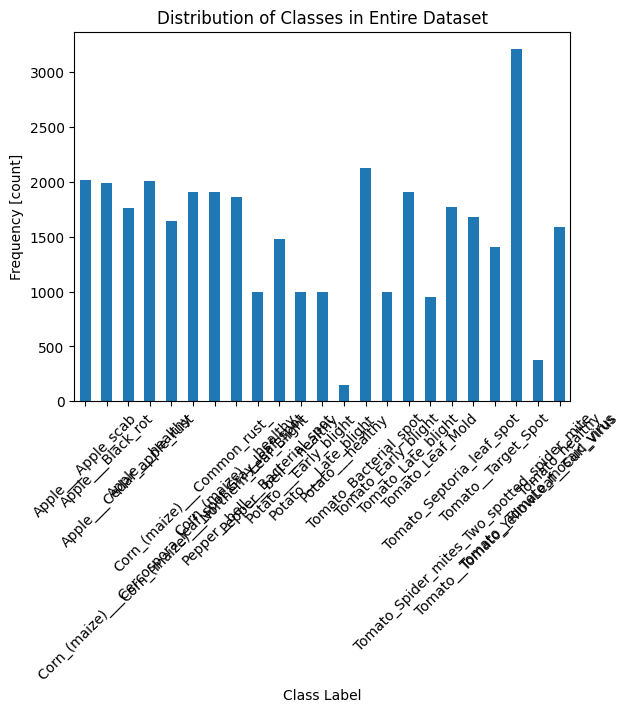

In [ ]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from modules.utils import class_counts


dataset_counts = class_counts(dataset)
dataset_counts.plot(kind='bar')
plt.xticks(rotation=45)
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Entire Dataset")
plt.show()

  0%|          | 0/28580 [00:00<?, ?it/s]

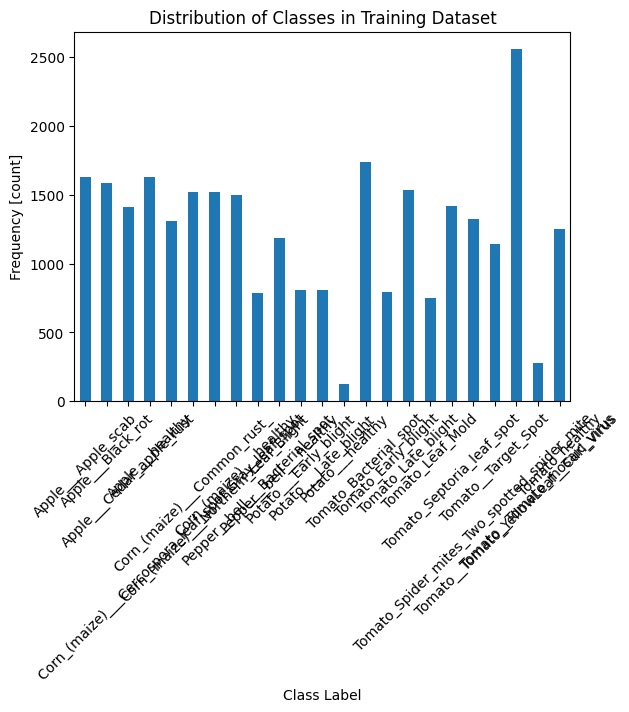

In [21]:
train_counts = class_counts(train_dataset)

train_counts.plot(kind='bar')
plt.xticks(rotation=45)
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset")
plt.show()

For the validation data.

  0%|          | 0/7145 [00:00<?, ?it/s]

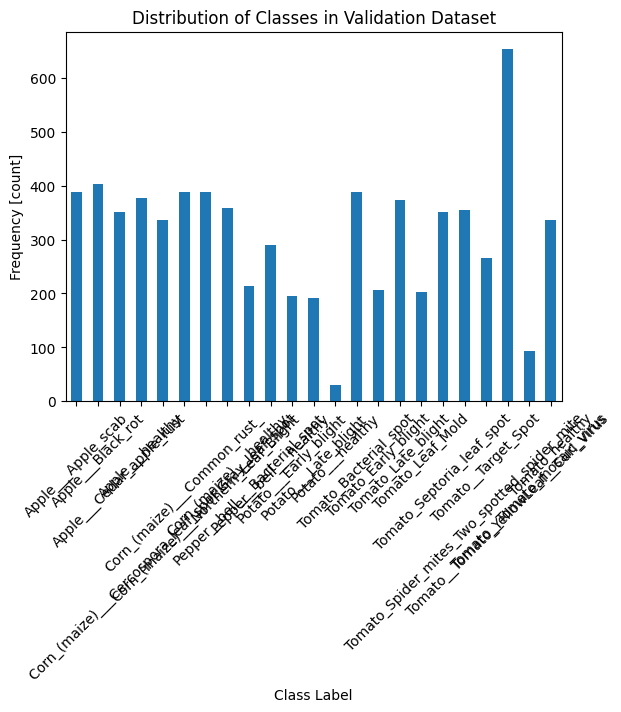

In [22]:
val_counts = class_counts(val_dataset)

val_counts.plot(kind='bar')
plt.xticks(rotation=45)
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Validation Dataset")
plt.show()

In [23]:
DataLoader

torch.utils.data.dataloader.DataLoader

In [24]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


`DataLoader` for validation data.

In [25]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


checking the shape of a batch of images and labels. using the `DataLoader` object and turn it into an iterator by using `iter`. Then with `next` we can fetch a batch of data.


In [26]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

image_shape = images.shape
print("Shape of batch of images", image_shape)

label_shape = labels.shape
print("Shape of batch of labels:", label_shape)

Shape of batch of images torch.Size([32, 3, 224, 224])
Shape of batch of labels: torch.Size([32])


In [27]:
labels

tensor([17,  1,  6,  3,  9,  9, 16,  0, 14,  1,  1,  8, 20, 13, 20,  2, 22,  6,
        10, 14,  1, 19,  6, 15,  2, 13, 21,  6, 17, 17,  2,  6])

### Building a CNN

In [28]:
model = torch.nn.Sequential()

In [29]:
# Convolutional layer 1 (sees 3x224x224 image tensor)
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
model.append(conv1)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [30]:
max_pool1 = nn.MaxPool2d(2, 2)
model.append(torch.nn.ReLU())
model.append(max_pool1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [31]:
# Convolutional layer 2 (sees 16x112x112 tensor)
conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
max_pool2 = nn.MaxPool2d(2, 2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [32]:
# Convolutional layer 3 (sees 32x56x56 tensor)
conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
max_pool3 = nn.MaxPool2d(2, 2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [33]:
model.append(torch.nn.Flatten())
model.append(nn.Dropout(0.5))

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
)

While we could go straight to our output $5$ classes from here, we'll get better performance by adding another layer. We're getting 64 * 28 * 28 outputs from the flattening layer, let's feed that into a dense layer.

In [34]:
# Linear layer (64 * 28 * 28 -> 500)
linear1 = torch.nn.Linear(in_features=50176, out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
)


the output layer

In [35]:
# Linear layer (500 -> 23)
output_layer = torch.nn.Linear(in_features=500, out_features=23)
model.append(output_layer)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=23, bias=True)
)


### Training the Model

the loss and optimizer we'll use. We'll go with the standard loss function in classification problems, cross entropy. For the optimizer we'll chose Adam optimizer.

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(loss_fn)
print("----------------------\n\n")
print(optimizer)

CrossEntropyLoss()
----------------------


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Using the CPU and placing our model on `device` and also printing the summary of the model.

In [37]:
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=23, bias=True)
)

In [38]:
height = 224
width = 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 23]                  --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Dropout: 1-11                          [32, 50176]               --
├─Linear: 1-12                           [32, 500]                 25,088,500



For training the model, we can import the functions we built in the last project. Same as before, we have a `training.py` file here, which contains the `train` function.

In [44]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from modules.training import train

In [45]:
train?

Signature:
train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device='cpu',
    use_train_accuracy=True,
)
Docstring: <no docstring>
File:      d:\worldquantuniversity\projects\plantdiseasedetection\modules\training.py
Type:      function

In [48]:
train_losses, valid_losses, train_accuracies, valid_accuracies = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=2,
    device=device
)

Training:   0%|          | 0/894 [00:00<?, ?it/s]

Scoring:   0%|          | 0/894 [00:00<?, ?it/s]

Scoring:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 0.02
    Training accuracy: 1.00
    Validation loss: 0.18
    Validation accuracy: 0.94


Training:   0%|          | 0/894 [00:00<?, ?it/s]

Scoring:   0%|          | 0/894 [00:00<?, ?it/s]

Scoring:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 0.02
    Training accuracy: 0.99
    Validation loss: 0.24
    Validation accuracy: 0.93


In [49]:
# Save the trained model
torch.save(model.state_dict(), "../artifacts/model.pth")

print("Model saved successfully!")

Model saved successfully!


In [50]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from modules.prediction import predict

probabilities_val = predict(model, val_loader)
predictions_val = torch.argmax(probabilities_val, dim=1)

print(predictions_val)

Predicting:   0%|          | 0/224 [00:00<?, ?it/s]

tensor([22,  4, 22,  ...,  8, 17, 20])


In [51]:
targets_val = torch.cat(
    [labels for _, labels in tqdm(val_loader, desc="Get Labels")]
).to(device)

Get Labels: 100%|██████████| 224/224 [00:24<00:00,  9.32it/s]


the confusion matrix.

<Figure size 2000x1600 with 0 Axes>

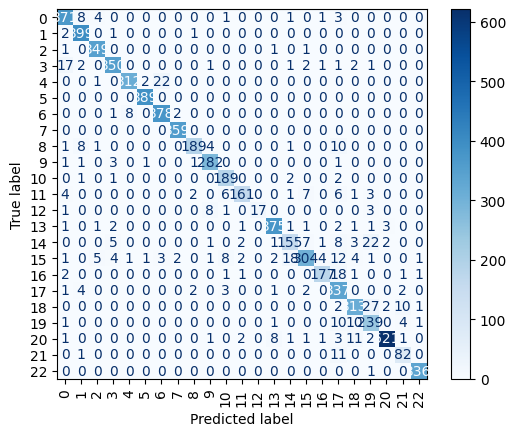

In [ ]:
cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)


plt.figure(figsize=(20, 16))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show()

The confusion matrix looks like a good model, which we expect due to 93% validation accuracy.

### Conclusion


But along the way, we practiced and learned some important things:
- We preprocessed our data to make it ready for deep learning. 
- We built a CNN with 3 convolutional and max pooling layers, followed by flattening and two dense layers.
- We used `nn.Sequential` to easily build our model's architecture by defining the order of the layers.
- Learnt that training the model for too many epochs produces an overfit model.


---
